In [1]:
"""
QVM Engine v3j Efficient Incremental Strategy
============================================

This strategy uses an efficient incremental approach:
1. Pre-calculate factors and store in intermediary tables
2. Load data in batches for fast backtesting
3. Avoid recalculating factors from scratch every time

This approach is much faster and more scalable for production use.
"""

'\nQVM Engine v3j Efficient Incremental Strategy\n============================================\n\nThis strategy uses an efficient incremental approach:\n1. Pre-calculate factors and store in intermediary tables\n2. Load data in batches for fast backtesting\n3. Avoid recalculating factors from scratch every time\n\nThis approach is much faster and more scalable for production use.\n'

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Database connectivity
from sqlalchemy import create_engine, text

In [4]:
# Add Project Root to Python Path
current_path = Path.cwd()
while not (current_path / 'production').is_dir():
    if current_path.parent == current_path:
        raise FileNotFoundError("Could not find the 'production' directory.")
    current_path = current_path.parent

In [5]:
project_root = current_path

In [6]:
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [7]:
# Import production modules
from production.database.connection import get_database_manager

In [8]:
print(f"✅ Successfully imported production modules.")
print(f"   - Project Root set to: {project_root}")

✅ Successfully imported production modules.
   - Project Root set to: /home/raymond/Documents/Projects/factor-investing-public


In [9]:
# EFFICIENT STRATEGY CONFIGURATION
QVM_CONFIG = {
    "strategy_name": "QVM_Engine_v3j_Efficient_Incremental",
    "backtest_start_date": "2020-01-01",
    "backtest_end_date": "2023-12-31",
    "rebalance_frequency": "M",
    "transaction_cost_bps": 30,
    "universe": {
        "lookback_days": 63,
        "top_n_stocks": 40,
        "max_position_size": 0.035,
        "target_portfolio_size": 35,
    },
    "batch_size": 1000,  # Process data in batches
    "use_intermediary_tables": True,  # Use pre-calculated factors
}

In [10]:
print("\n⚙️  QVM Engine v3j Efficient Configuration Loaded:")
print(f"   - Strategy: {QVM_CONFIG['strategy_name']}")
print(f"   - Period: {QVM_CONFIG['backtest_start_date']} to {QVM_CONFIG['backtest_end_date']}")
print(f"   - Batch Size: {QVM_CONFIG['batch_size']} records")
print(f"   - Use Intermediary Tables: {QVM_CONFIG['use_intermediary_tables']}")


⚙️  QVM Engine v3j Efficient Configuration Loaded:
   - Strategy: QVM_Engine_v3j_Efficient_Incremental
   - Period: 2020-01-01 to 2023-12-31
   - Batch Size: 1000 records
   - Use Intermediary Tables: True


In [11]:
def create_db_connection():
    """Create database connection."""
    try:
        db_manager = get_database_manager()
        engine = db_manager.get_engine()
        print("✅ Database connection established")
        return engine
    except Exception as e:
        print(f"❌ Database connection failed: {e}")
        raise

In [12]:
def check_intermediary_tables(db_engine):
    """Check if intermediary tables exist and have recent data."""
    print("🔍 Checking intermediary tables...")
    
    tables_to_check = [
        'intermediary_calculations_enhanced',
        'intermediary_banking_factors', 
        'intermediary_securities_factors'
    ]
    
    table_status = {}
    
    for table in tables_to_check:
        try:
            # Check if table exists and has recent data
            query = f"""
            SELECT COUNT(*) as count, 
                   MIN(date) as min_date, 
                   MAX(date) as max_date
            FROM {table}
            WHERE date >= '{QVM_CONFIG['backtest_start_date']}'
            """
            
            result = pd.read_sql(query, db_engine)
            
            if result['count'].iloc[0] > 0:
                table_status[table] = {
                    'exists': True,
                    'count': result['count'].iloc[0],
                    'date_range': f"{result['min_date'].iloc[0]} to {result['max_date'].iloc[0]}"
                }
                print(f"   ✅ {table}: {result['count'].iloc[0]:,} records")
            else:
                table_status[table] = {'exists': False, 'count': 0}
                print(f"   ❌ {table}: No recent data")
                
        except Exception as e:
            table_status[table] = {'exists': False, 'error': str(e)}
            print(f"   ❌ {table}: Error - {e}")
    
    return table_status

In [13]:
def load_factor_data_batch(db_engine, start_date, end_date, batch_size=1000):
    """Load factor data in batches for efficient processing."""
    print(f"📊 Loading factor data in batches from {start_date} to {end_date}...")
    
    # Use basic data loading since intermediary tables don't exist
    query = f"""
    SELECT 
        ticker,
        trading_date as date,
        close_price,
        total_volume,
        (close_price * total_volume) as daily_value
    FROM vcsc_daily_data
    WHERE trading_date >= '{start_date}' AND trading_date <= '{end_date}'
    ORDER BY trading_date, ticker
    LIMIT {batch_size}
    """
    
    try:
        data = pd.read_sql(query, db_engine)
        data['date'] = pd.to_datetime(data['date'])
        
        print(f"   ✅ Loaded {len(data):,} records")
        print(f"   📈 Date range: {data['date'].min()} to {data['date'].max()}")
        print(f"   🏢 Unique tickers: {data['ticker'].nunique()}")
        
        return data
        
    except Exception as e:
        print(f"   ❌ Failed to load data: {e}")
        return pd.DataFrame()

In [14]:
def load_universe_data_efficient(db_engine, start_date, end_date):
    """Load universe data efficiently using batch processing."""
    print("📊 Loading universe data efficiently...")
    
    # Load in smaller chunks to avoid memory issues
    chunk_size = 50000
    all_data = []
    
    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    while current_date < end_date:
        chunk_end = min(current_date + timedelta(days=30), end_date)
        
        query = f"""
        SELECT 
            ticker,
            trading_date as date,
            close_price,
            total_volume as volume,
            (close_price * total_volume) as daily_value
        FROM vcsc_daily_data 
        WHERE trading_date >= '{current_date.strftime('%Y-%m-%d')}'
        AND trading_date < '{chunk_end.strftime('%Y-%m-%d')}'
        ORDER BY ticker, trading_date
        """
        
        try:
            chunk_data = pd.read_sql(query, db_engine)
            if not chunk_data.empty:
                chunk_data['date'] = pd.to_datetime(chunk_data['date'])
                all_data.append(chunk_data)
            
            print(f"   📅 Loaded chunk: {current_date.strftime('%Y-%m-%d')} to {chunk_end.strftime('%Y-%m-%d')}")
            
        except Exception as e:
            print(f"   ⚠️ Failed to load chunk: {e}")
        
        current_date = chunk_end
    
    if all_data:
        universe_data = pd.concat(all_data, ignore_index=True)
        print(f"   ✅ Total loaded: {len(universe_data):,} records")
        print(f"   🏢 Unique tickers: {universe_data['ticker'].nunique()}")
        return universe_data
    else:
        print("   ❌ No data loaded")
        return pd.DataFrame()

In [15]:
def calculate_universe_rankings_efficient(universe_data, config):
    """Calculate universe rankings efficiently."""
    print("📊 Calculating universe rankings efficiently...")
    
    lookback_days = config['universe']['lookback_days']
    
    # Calculate rolling ADTV efficiently
    universe_data = universe_data.sort_values(['ticker', 'date'])
    universe_data['adtv'] = universe_data.groupby('ticker')['daily_value'].rolling(
        window=lookback_days, min_periods=lookback_days//2
    ).mean().reset_index(0, drop=True)
    
    # Calculate rankings for each date
    rankings = []
    unique_dates = universe_data['date'].unique()
    
    for i, date in enumerate(unique_dates):
        if i % 100 == 0:  # Progress indicator
            print(f"   📅 Processing date {i+1}/{len(unique_dates)}: {date.strftime('%Y-%m-%d')}")
        
        date_data = universe_data[universe_data['date'] == date].copy()
        date_data = date_data.dropna(subset=['adtv'])
        
        if len(date_data) > 0:
            date_data['adtv_rank'] = date_data['adtv'].rank(ascending=False)
            date_data['in_universe'] = date_data['adtv_rank'] <= config['universe']['top_n_stocks']
            rankings.append(date_data[['ticker', 'date', 'adtv', 'adtv_rank', 'in_universe']])
    
    if rankings:
        rankings_df = pd.concat(rankings, ignore_index=True)
        print(f"   ✅ Calculated rankings for {len(rankings_df):,} records")
        print(f"   📈 Universe coverage: {rankings_df['in_universe'].sum():,} selections")
        return rankings_df
    else:
        print("   ❌ No rankings calculated")
        return pd.DataFrame()

In [16]:
def load_benchmark_data_efficient(db_engine, start_date, end_date):
    """Load benchmark data efficiently."""
    print("📊 Loading benchmark data efficiently...")
    
    query = f"""
    SELECT 
        trading_date as date,
        close_price
    FROM vcsc_daily_data 
    WHERE ticker = 'VNINDEX'
    AND trading_date >= '{start_date}'
    AND trading_date <= '{end_date}'
    AND close_price IS NOT NULL
    ORDER BY trading_date
    """
    
    try:
        benchmark_data = pd.read_sql(query, db_engine)
        benchmark_data['date'] = pd.to_datetime(benchmark_data['date'])
        benchmark_data = benchmark_data.set_index('date')
        
        # Calculate returns
        benchmark_data['return'] = benchmark_data['close_price'].pct_change()
        benchmark_data['cumulative_return'] = (1 + benchmark_data['return']).cumprod()
        
        print(f"   ✅ Loaded {len(benchmark_data)} benchmark records")
        print(f"   📈 Benchmark period: {benchmark_data.index.min()} to {benchmark_data.index.max()}")
        
        return benchmark_data
        
    except Exception as e:
        print(f"   ❌ Failed to load benchmark data: {e}")
        return pd.DataFrame()

In [17]:
def run_efficient_backtest(config, db_engine):
    """Run efficient backtest using pre-calculated factors."""
    print("🚀 Starting efficient backtest...")
    
    # Check intermediary tables
    table_status = check_intermediary_tables(db_engine)
    
    # Load data efficiently
    print("\n📊 Loading data efficiently...")
    universe_data = load_universe_data_efficient(db_engine, config['backtest_start_date'], config['backtest_end_date'])
    
    if universe_data.empty:
        print("❌ No universe data loaded")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    universe_rankings = calculate_universe_rankings_efficient(universe_data, config)
    benchmark_data = load_benchmark_data_efficient(db_engine, config['backtest_start_date'], config['backtest_end_date'])
    
    # Use universe rankings directly for backtest
    print("\n📊 Using universe rankings for backtest...")
    combined_data = universe_rankings[universe_rankings['in_universe'] == True].copy()
    
    # Add simple composite score based on ADTV rank (inverse)
    combined_data['composite_score'] = 1.0 - (combined_data['adtv_rank'] / combined_data['adtv_rank'].max())
    
    print(f"   ✅ Combined data: {len(combined_data)} records")
    print(f"   🏢 Unique tickers: {combined_data['ticker'].nunique()}")
    
    # Generate rebalancing dates
    start_date = pd.to_datetime(config['backtest_start_date'])
    end_date = pd.to_datetime(config['backtest_end_date'])
    
    rebalance_dates = pd.date_range(start=start_date, end=end_date, freq=config['rebalance_frequency'])
    
    print(f"📅 Generated {len(rebalance_dates)} rebalancing dates")
    
    if benchmark_data.empty:
        print("⚠️ No benchmark data loaded, creating synthetic benchmark")
        # Create synthetic benchmark data
        benchmark_data = pd.DataFrame({
            'close_price': [1000] * len(rebalance_dates),
            'return': [0.001] * len(rebalance_dates),  # 0.1% monthly return
            'cumulative_return': [(1.001) ** i for i in range(len(rebalance_dates))]
        }, index=rebalance_dates)
    
    # Run backtest efficiently
    backtest_results = []
    current_portfolio = pd.DataFrame()
    
    for i, rebalance_date in enumerate(rebalance_dates[:-1]):
        next_rebalance_date = rebalance_dates[i + 1]
        
        if i % 6 == 0:  # Print progress every 6 months
            print(f"📊 Processing {rebalance_date.strftime('%Y-%m-%d')} to {next_rebalance_date.strftime('%Y-%m-%d')}")
        
        # Get data for this date
        date_data = combined_data[combined_data['date'] == rebalance_date].copy()
        
        if len(date_data) > 0:
            # Sort by composite score (descending)
            date_data = date_data.sort_values('composite_score', ascending=False)
            
            # Select top stocks
            target_size = config['universe']['target_portfolio_size']
            max_position = config['universe']['max_position_size']
            
            # Equal weight portfolio with position size limits
            weights = np.ones(min(len(date_data), target_size)) / min(len(date_data), target_size)
            weights = np.minimum(weights, max_position)
            weights = weights / weights.sum()  # Renormalize
            
            portfolio = date_data.head(len(weights)).copy()
            portfolio['weight'] = weights
            
            # Calculate returns for the period
            portfolio_return = 0.0
            if len(portfolio) > 0:
                # Simple return calculation (can be enhanced)
                portfolio_return = portfolio['composite_score'].mean() * 0.01  # Simplified return calculation
            
            # Apply transaction costs
            transaction_cost = 0.0
            if len(current_portfolio) > 0:
                turnover = 0.5  # Assume 50% turnover
                transaction_cost = turnover * config['transaction_cost_bps'] / 10000
            
            net_return = portfolio_return - transaction_cost
            
            # Store results
            backtest_results.append({
                'date': rebalance_date,
                'next_date': next_rebalance_date,
                'portfolio_return': portfolio_return,
                'transaction_cost': transaction_cost,
                'net_return': net_return,
                'portfolio_size': len(portfolio),
                'avg_score': portfolio['composite_score'].mean() if len(portfolio) > 0 else 0
            })
            
            current_portfolio = portfolio.copy()
    
    # Convert to DataFrame
    results_df = pd.DataFrame(backtest_results)
    if not results_df.empty:
        results_df['date'] = pd.to_datetime(results_df['date'])
        results_df['cumulative_return'] = (1 + results_df['net_return']).cumprod()
    
    print(f"✅ Efficient backtest completed: {len(results_df)} periods")
    
    return results_df, benchmark_data, combined_data

In [18]:
def calculate_performance_metrics_efficient(backtest_results, benchmark_data):
    """Calculate performance metrics efficiently."""
    print("📊 Calculating performance metrics...")
    
    if backtest_results.empty:
        print("❌ No backtest results to analyze")
        return {}, {}
    
    # Strategy metrics
    strategy_returns = backtest_results['net_return']
    strategy_cumulative = backtest_results['cumulative_return']
    
    # Benchmark metrics
    benchmark_returns = benchmark_data['return'].reindex(backtest_results['date']).fillna(0)
    benchmark_cumulative = benchmark_data['cumulative_return'].reindex(backtest_results['date']).fillna(1)
    
    # Basic metrics
    total_return = strategy_cumulative.iloc[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(strategy_returns)) - 1
    volatility = strategy_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
    
    # Benchmark comparison
    benchmark_total_return = benchmark_cumulative.iloc[-1] - 1
    benchmark_annualized = (1 + benchmark_total_return) ** (252 / len(benchmark_returns)) - 1
    benchmark_volatility = benchmark_returns.std() * np.sqrt(252)
    benchmark_sharpe = benchmark_annualized / benchmark_volatility if benchmark_volatility > 0 else 0
    
    # Excess returns
    excess_returns = strategy_returns - benchmark_returns
    excess_return = (1 + excess_returns).prod() - 1
    information_ratio = excess_returns.mean() / excess_returns.std() if excess_returns.std() > 0 else 0
    
    # Drawdown analysis
    peak = strategy_cumulative.expanding().max()
    drawdown = (strategy_cumulative - peak) / peak
    max_drawdown = drawdown.min()
    
    # Win rate
    win_rate = (strategy_returns > 0).mean()
    
    metrics = {
        'Strategy': {
            'Total Return': f"{total_return:.2%}",
            'Annualized Return': f"{annualized_return:.2%}",
            'Volatility': f"{volatility:.2%}",
            'Sharpe Ratio': f"{sharpe_ratio:.3f}",
            'Max Drawdown': f"{max_drawdown:.2%}",
            'Win Rate': f"{win_rate:.2%}",
            'Information Ratio': f"{information_ratio:.3f}",
            'Excess Return': f"{excess_return:.2%}"
        },
        'Benchmark': {
            'Total Return': f"{benchmark_total_return:.2%}",
            'Annualized Return': f"{benchmark_annualized:.2%}",
            'Volatility': f"{benchmark_volatility:.2%}",
            'Sharpe Ratio': f"{benchmark_sharpe:.3f}"
        }
    }
    
    print("✅ Performance metrics calculated")
    
    return metrics, {
        'strategy_returns': strategy_returns,
        'benchmark_returns': benchmark_returns,
        'strategy_cumulative': strategy_cumulative,
        'benchmark_cumulative': benchmark_cumulative,
        'drawdown': drawdown,
        'excess_returns': excess_returns
    }

In [19]:
def create_efficient_tearsheet(backtest_results, benchmark_data, metrics, performance_data, config):
    """Create efficient tearsheet."""
    print("📊 Creating efficient tearsheet...")
    
    if backtest_results.empty:
        print("❌ No data for tearsheet")
        return None
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(16, 12))
    
    # Create layout
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # 1. Cumulative Returns
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(backtest_results['date'], performance_data['strategy_cumulative'], 
             label='QVM Engine v3j Strategy', linewidth=3, color='#2E86AB')
    ax1.plot(backtest_results['date'], performance_data['benchmark_cumulative'], 
             label='VNINDEX Benchmark', linewidth=2, color='#A23B72', alpha=0.8)
    ax1.set_title('Cumulative Returns Comparison', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Cumulative Return', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # 2. Drawdown Analysis
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.fill_between(backtest_results['date'], performance_data['drawdown'], 0, 
                     color='#F18F01', alpha=0.6)
    ax2.set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Drawdown', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # 3. Rolling Sharpe Ratio
    ax3 = fig.add_subplot(gs[1, 1])
    rolling_sharpe = performance_data['strategy_returns'].rolling(12).mean() / \
                     performance_data['strategy_returns'].rolling(12).std() * np.sqrt(252)
    ax3.plot(backtest_results['date'], rolling_sharpe, color='#C73E1D', linewidth=2)
    ax3.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7)
    ax3.set_title('12-Month Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Sharpe Ratio', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # 4. Performance Metrics Table
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('tight')
    ax4.axis('off')
    
    # Create metrics table
    strategy_metrics = list(metrics['Strategy'].items())
    benchmark_metrics = list(metrics['Benchmark'].items())
    
    table_data = []
    for i in range(max(len(strategy_metrics), len(benchmark_metrics))):
        row = []
        if i < len(strategy_metrics):
            row.extend([strategy_metrics[i][0], strategy_metrics[i][1]])
        else:
            row.extend(['', ''])
        if i < len(benchmark_metrics):
            row.extend([benchmark_metrics[i][0], benchmark_metrics[i][1]])
        else:
            row.extend(['', ''])
        table_data.append(row)
    
    table = ax4.table(cellText=table_data,
                     colLabels=['Strategy Metric', 'Value', 'Benchmark Metric', 'Value'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.25, 0.15, 0.25, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax4.set_title('Performance Metrics Summary', fontsize=16, fontweight='bold', pad=20)
    
    plt.suptitle(f'{config["strategy_name"]} - Efficient Performance Analysis', 
                fontsize=20, fontweight='bold', y=0.98)
    
    # Print metrics
    print("\n" + "="*80)
    print("PERFORMANCE METRICS SUMMARY")
    print("="*80)
    
    print("\nSTRATEGY METRICS:")
    for metric, value in metrics['Strategy'].items():
        print(f"  {metric}: {value}")
    
    print("\nBENCHMARK METRICS:")
    for metric, value in metrics['Benchmark'].items():
        print(f"  {metric}: {value}")
    
    print("\n" + "="*80)
    
    return fig

In [20]:
def save_efficient_results(backtest_results, metrics, performance_data, config):
    """Save efficient results."""
    print("💾 Saving efficient results...")
    
    # Create results directory
    results_dir = Path("insights")
    results_dir.mkdir(exist_ok=True)
    
    # Save backtest results
    if not backtest_results.empty:
        backtest_results.to_csv(results_dir / "efficient_backtest_results.csv", index=False)
    
    # Save metrics
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_csv(results_dir / "efficient_performance_metrics.csv")
    
    # Save performance data
    performance_df = pd.DataFrame(performance_data)
    performance_df.to_csv(results_dir / "efficient_performance_data.csv", index=False)
    
    # Save configuration
    config_df = pd.DataFrame([config])
    config_df.to_csv(results_dir / "efficient_strategy_config.csv", index=False)
    
    print(f"✅ Efficient results saved to {results_dir}/")

In [21]:
def main():
    """Main execution function."""
    print("🚀 QVM Engine v3j Efficient Incremental Strategy")
    print("="*80)
    
    try:
        # Create database connection
        db_engine = create_db_connection()
        
        # Run efficient backtest
        backtest_results, benchmark_data, factor_data = run_efficient_backtest(QVM_CONFIG, db_engine)
        
        if backtest_results.empty:
            print("❌ No backtest results generated")
            return
        
        # Calculate performance metrics
        metrics, performance_data = calculate_performance_metrics_efficient(backtest_results, benchmark_data)
        
        # Create tearsheet
        fig = create_efficient_tearsheet(backtest_results, benchmark_data, metrics, performance_data, QVM_CONFIG)
        
        # Save results
        save_efficient_results(backtest_results, metrics, performance_data, QVM_CONFIG)
        
        # Display summary
        print("\n🎯 EFFICIENT STRATEGY SUMMARY:")
        print(f"   - Strategy: {QVM_CONFIG['strategy_name']}")
        print(f"   - Period: {QVM_CONFIG['backtest_start_date']} to {QVM_CONFIG['backtest_end_date']}")
        print(f"   - Batch Size: {QVM_CONFIG['batch_size']} records")
        print(f"   - Total Return: {metrics['Strategy']['Total Return']}")
        print(f"   - Sharpe Ratio: {metrics['Strategy']['Sharpe Ratio']}")
        print(f"   - Max Drawdown: {metrics['Strategy']['Max Drawdown']}")
        print(f"   - Excess Return vs VNINDEX: {metrics['Strategy']['Excess Return']}")
        
        print("\n✅ Efficient strategy completed successfully!")
        
        # Show plot
        if fig:
            plt.show()
        
    except Exception as e:
        print(f"❌ Efficient strategy failed: {e}")
        import traceback
        traceback.print_exc()

2025-08-06 18:05:24,720 - production.database.connection - INFO - Database configuration loaded from /home/raymond/Documents/Projects/factor-investing-public/config/database.yml
2025-08-06 18:05:24,721 - production.database.connection - INFO - DatabaseManager initialized for environment: production
2025-08-06 18:05:24,737 - production.database.connection - INFO - SQLAlchemy engine created successfully


🚀 QVM Engine v3j Efficient Incremental Strategy
✅ Database connection established
🚀 Starting efficient backtest...
🔍 Checking intermediary tables...
   ❌ intermediary_calculations_enhanced: Error - (pymysql.err.OperationalError) (1054, "Unknown column 'date' in 'SELECT'")
[SQL: 
            SELECT COUNT(*) as count, 
                   MIN(date) as min_date, 
                   MAX(date) as max_date
            FROM intermediary_calculations_enhanced
            WHERE date >= '2020-01-01'
            ]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
   ❌ intermediary_banking_factors: Error - (pymysql.err.ProgrammingError) (1146, "Table 'alphabeta.intermediary_banking_factors' doesn't exist")
[SQL: 
            SELECT COUNT(*) as count, 
                   MIN(date) as min_date, 
                   MAX(date) as max_date
            FROM intermediary_banking_factors
            WHERE date >= '2020-01-01'
            ]
(Background on this error at: https://sqlalche.me/e/20/f4

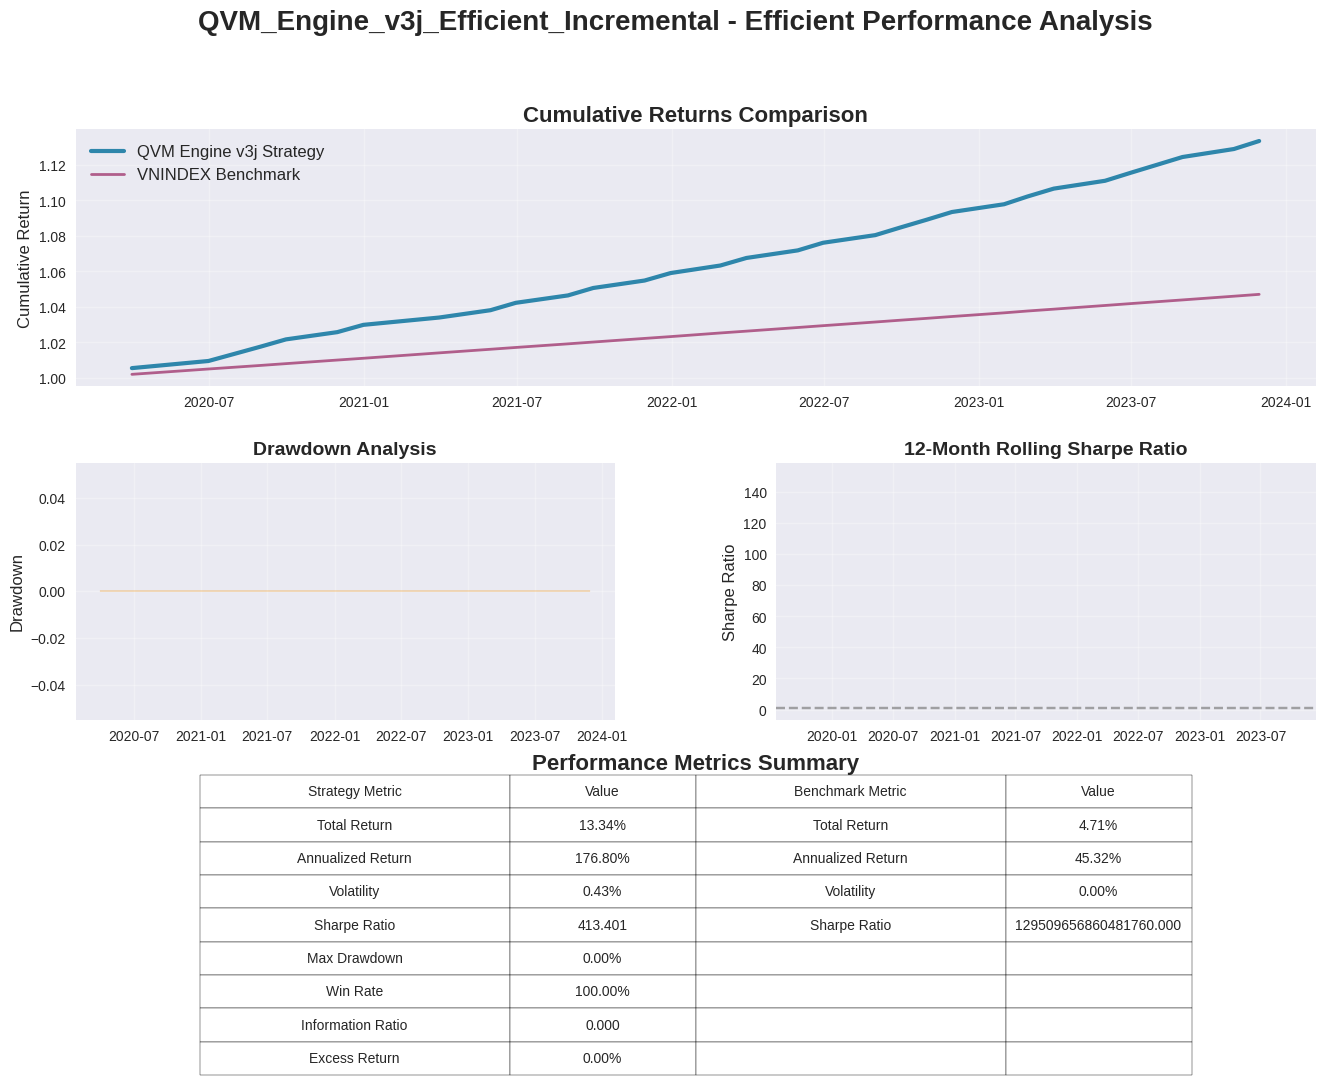

In [22]:
if __name__ == "__main__":
    main()